In [2]:
%matplotlib inline


# Clustering text documents using k-means

This is an example showing how the scikit-learn API can be used to cluster
documents by topics using a [Bag of Words approach](https://en.wikipedia.org/wiki/Bag-of-words_model).

Two algorithms are demoed: :class:`~sklearn.cluster.KMeans` and its more
scalable variant, :class:`~sklearn.cluster.MiniBatchKMeans`. Additionally,
latent semantic analysis is used to reduce dimensionality and discover latent
patterns in the data.

This example uses two different text vectorizers: a
:class:`~sklearn.feature_extraction.text.TfidfVectorizer` and a
:class:`~sklearn.feature_extraction.text.HashingVectorizer`. See the example
notebook `sphx_glr_auto_examples_text_plot_hashing_vs_dict_vectorizer.py`
for more information on vectorizers and a comparison of their processing times.

For document analysis via a supervised learning approach, see the example script
`sphx_glr_auto_examples_text_plot_document_classification_20newsgroups.py`.


In [3]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Lars Buitinck
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Arturo Amor <david-arturo.amor-quiroz@inria.fr>
# License: BSD 3 clause

## Loading text data

We load data from `20newsgroups_dataset`, which comprises around 18,000
newsgroups posts on 20 topics. For illustrative purposes and to reduce the
computational cost, we select a subset of 4 topics only accounting for around
3,400 documents. See the example
`sphx_glr_auto_examples_text_plot_document_classification_20newsgroups.py`
to gain intuition on the overlap of such topics.

Notice that, by default, the text samples contain some message metadata such
as `"headers"`, `"footers"` (signatures) and `"quotes"` to other posts. We use
the `remove` parameter from :func:`~sklearn.datasets.fetch_20newsgroups` to
strip those features and have a more sensible clustering problem.



In [10]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)

labels = dataset.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(dataset.data)} documents - {true_k} categories")

3387 documents - 4 categories


In [11]:
import pandas as pd
from IPython.display import display, HTML
display(HTML(pd.DataFrame(dataset.data).sample(20).to_html()))


## Quantifying the quality of clustering results

In this section we define a function to score different clustering pipelines
using several metrics.

Clustering algorithms are fundamentally unsupervised learning methods.
However, since we happen to have class labels for this specific dataset, it is
possible to use evaluation metrics that leverage this "supervised" ground
truth information to quantify the quality of the resulting clusters. Examples
of such metrics are the following:

- homogeneity, which quantifies how much clusters contain only members of a
  single class;

- completeness, which quantifies how much members of a given class are
  assigned to the same clusters;

- V-measure, the harmonic mean of completeness and homogeneity;

- Rand-Index, which measures how frequently pairs of data points are grouped
  consistently according to the result of the clustering algorithm and the
  ground truth class assignment;

- Adjusted Rand-Index, a chance-adjusted Rand-Index such that random cluster
  assignment have an ARI of 0.0 in expectation.

If the ground truth labels are not known, evaluation can only be performed
using the model results itself. In that case, the Silhouette Coefficient comes
in handy.

For more reference, see `clustering_evaluation`.



In [12]:
from collections import defaultdict
from sklearn import metrics
from time import time

evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

## K-means clustering on text features

Two feature extraction methods are used in this example:

- :class:`~sklearn.feature_extraction.text.TfidfVectorizer` uses an in-memory
  vocabulary (a Python dict) to map the most frequent words to features
  indices and hence compute a word occurrence frequency (sparse) matrix. The
  word frequencies are then reweighted using the Inverse Document Frequency
  (IDF) vector collected feature-wise over the corpus.

- :class:`~sklearn.feature_extraction.text.HashingVectorizer` hashes word
  occurrences to a fixed dimensional space, possibly with collisions. The word
  count vectors are then normalized to each have l2-norm equal to one
  (projected to the euclidean unit-sphere) which seems to be important for
  k-means to work in high dimensional space.

Furthermore it is possible to post-process those extracted features using
dimensionality reduction. We will explore the impact of those choices on the
clustering quality in the following.

### Feature Extraction using TfidfVectorizer

We first benchmark the estimators using a dictionary vectorizer along with an
IDF normalization as provided by
:class:`~sklearn.feature_extraction.text.TfidfVectorizer`.



In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(dataset.data)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 0.563 s
n_samples: 3387, n_features: 7929


After ignoring terms that appear in more than 50% of the documents (as set by
`max_df=0.5`) and terms that are not present in at least 5 documents (set by
`min_df=5`), the resulting number of unique terms `n_features` is around
8,000. We can additionally quantify the sparsity of the `X_tfidf` matrix as
the fraction of non-zero entries devided by the total number of elements.



In [14]:
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

0.007


We find that around 0.7% of the entries of the `X_tfidf` matrix are non-zero.


### Clustering sparse data with k-means

As both :class:`~sklearn.cluster.KMeans` and
:class:`~sklearn.cluster.MiniBatchKMeans` optimize a non-convex objective
function, their clustering is not guaranteed to be optimal for a given random
init. Even further, on sparse high-dimensional data such as text vectorized
using the Bag of Words approach, k-means can initialize centroids on extremely
isolated data points. Those data points can stay their own centroids all
along.

The following code illustrates how the previous phenomenon can sometimes lead
to highly imbalanced clusters, depending on the random initialization:



In [15]:
from sklearn.cluster import KMeans

for seed in range(5):
    kmeans = KMeans(
        n_clusters=true_k,
        max_iter=100,
        n_init=1,
        random_state=seed,
    ).fit(X_tfidf)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements asigned to each cluster: {cluster_sizes}")
print()
print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes}"
)

Number of elements asigned to each cluster: [2050  711  180  446]
Number of elements asigned to each cluster: [1689  638  480  580]
Number of elements asigned to each cluster: [   1    1    1 3384]
Number of elements asigned to each cluster: [1887  311  332  857]
Number of elements asigned to each cluster: [1688  636  454  609]

True number of documents in each category according to the class labels: [799 973 987 628]


To avoid this problem, one possibility is to increase the number of runs with
independent random initiations `n_init`. In such case the clustering with the
best inertia (objective function of k-means) is chosen.



In [16]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=5,
)

fit_and_evaluate(kmeans, X_tfidf, name="KMeans\non tf-idf vectors")

clustering done in 0.26 ± 0.07 s 
Homogeneity: 0.351 ± 0.006
Completeness: 0.402 ± 0.012
V-measure: 0.375 ± 0.008
Adjusted Rand-Index: 0.207 ± 0.015
Silhouette Coefficient: 0.007 ± 0.000


All those clustering evaluation metrics have a maximum value of 1.0 (for a
perfect clustering result). Higher values are better. Values of the Adjusted
Rand-Index close to 0.0 correspond to a random labeling. Notice from the
scores above that the cluster assignment is indeed well above chance level,
but the overall quality can certainly improve.

Keep in mind that the class labels may not reflect accurately the document
topics and therefore metrics that use labels are not necessarily the best to
evaluate the quality of our clustering pipeline.

### Performing dimensionality reduction using LSA

A `n_init=1` can still be used as long as the dimension of the vectorized
space is reduced first to make k-means more stable. For such purpose we use
:class:`~sklearn.decomposition.TruncatedSVD`, which works on term count/tf-idf
matrices. Since SVD results are not normalized, we redo the normalization to
improve the :class:`~sklearn.cluster.KMeans` result. Using SVD to reduce the
dimensionality of TF-IDF document vectors is often known as [latent semantic
analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis) (LSA) in
the information retrieval and text mining literature.



In [17]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer


lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 0.789 s
Explained variance of the SVD step: 18.4%


Using a single initialization means the processing time will be reduced for
both :class:`~sklearn.cluster.KMeans` and
:class:`~sklearn.cluster.MiniBatchKMeans`.



In [18]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

clustering done in 0.03 ± 0.01 s 
Homogeneity: 0.402 ± 0.017
Completeness: 0.422 ± 0.012
V-measure: 0.412 ± 0.015
Adjusted Rand-Index: 0.303 ± 0.006
Silhouette Coefficient: 0.030 ± 0.001


We can observe that clustering on the LSA representation of the document is
significantly faster (both because of `n_init=1` and because the
dimensionality of the LSA feature space is much smaller). Furthermore, all the
clustering evaluation metrics have improved. We repeat the experiment with
:class:`~sklearn.cluster.MiniBatchKMeans`.



In [19]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(
    n_clusters=true_k,
    n_init=1,
    init_size=1000,
    batch_size=1000,
)

fit_and_evaluate(
    minibatch_kmeans,
    X_lsa,
    name="MiniBatchKMeans\nwith LSA on tf-idf vectors",
)

clustering done in 0.02 ± 0.01 s 
Homogeneity: 0.289 ± 0.145
Completeness: 0.353 ± 0.076
V-measure: 0.304 ± 0.136
Adjusted Rand-Index: 0.255 ± 0.141
Silhouette Coefficient: 0.019 ± 0.017


### Top terms per cluster

Since :class:`~sklearn.feature_extraction.text.TfidfVectorizer` can be
inverted we can identify the cluster centers, which provide an intuition of
the most influential words **for each cluster**. See the example script
`sphx_glr_auto_examples_text_plot_document_classification_20newsgroups.py`
for a comparison with the most predictive words **for each target class**.



In [20]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: just think don like know time ve said did say 
Cluster 1: space launch orbit shuttle nasa earth moon like mission lunar 
Cluster 2: graphics thanks image file files program know looking help format 
Cluster 3: god people jesus bible don believe christian think say religion 


### HashingVectorizer
An alternative vectorization can be done using a
:class:`~sklearn.feature_extraction.text.HashingVectorizer` instance, which
does not provide IDF weighting as this is a stateless model (the fit method
does nothing). When IDF weighting is needed it can be added by pipelining the
:class:`~sklearn.feature_extraction.text.HashingVectorizer` output to a
:class:`~sklearn.feature_extraction.text.TfidfTransformer` instance. In this
case we also add LSA to the pipeline to reduce the dimension and sparcity of
the hashed vector space.



In [21]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

lsa_vectorizer = make_pipeline(
    HashingVectorizer(stop_words="english", n_features=50_000),
    TfidfTransformer(),
    TruncatedSVD(n_components=100, random_state=0),
    Normalizer(copy=False),
)

t0 = time()
X_hashed_lsa = lsa_vectorizer.fit_transform(dataset.data)
print(f"vectorization done in {time() - t0:.3f} s")

vectorization done in 3.751 s


One can observe that the LSA step takes a relatively long time to fit,
especially with hashed vectors. The reason is that a hashed space is typically
large (set to `n_features=50_000` in this example). One can try lowering the
number of features at the expense of having a larger fraction of features with
hash collisions as shown in the example notebook
`sphx_glr_auto_examples_text_plot_hashing_vs_dict_vectorizer.py`.

We now fit and evaluate the `kmeans` and `minibatch_kmeans` instances on this
hashed-lsa-reduced data:



In [22]:
fit_and_evaluate(kmeans, X_hashed_lsa, name="KMeans\nwith LSA on hashed vectors")

clustering done in 0.02 ± 0.01 s 
Homogeneity: 0.398 ± 0.008
Completeness: 0.447 ± 0.015
V-measure: 0.421 ± 0.011
Adjusted Rand-Index: 0.322 ± 0.010
Silhouette Coefficient: 0.030 ± 0.002


In [23]:
fit_and_evaluate(
    minibatch_kmeans,
    X_hashed_lsa,
    name="MiniBatchKMeans\nwith LSA on hashed vectors",
)

clustering done in 0.04 ± 0.01 s 
Homogeneity: 0.342 ± 0.055
Completeness: 0.353 ± 0.049
V-measure: 0.347 ± 0.052
Adjusted Rand-Index: 0.303 ± 0.057
Silhouette Coefficient: 0.026 ± 0.004


Both methods lead to good results that are similar to running the same models
on the traditional LSA vectors (without hashing).

## Clustering evaluation summary



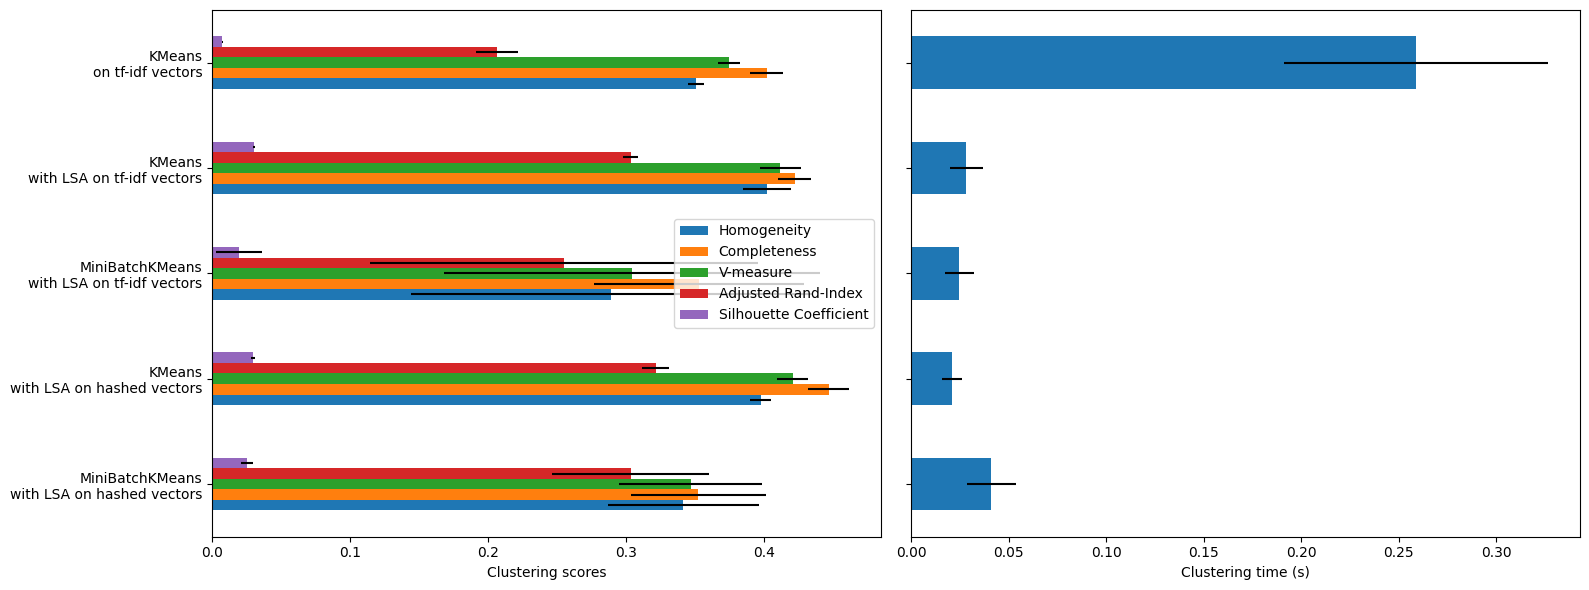

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()

:class:`~sklearn.cluster.KMeans` and :class:`~sklearn.cluster.MiniBatchKMeans`
suffer from the phenomenon called the [Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) for high dimensional
datasets such as text data. That is the reason why the overall scores improve
when using LSA. Using LSA reduced data also improves the stability and
requires lower clustering time, though keep in mind that the LSA step itself
takes a long time, especially with hashed vectors.

The Silhouette Coefficient is defined between 0 and 1. In all cases we obtain
values close to 0 (even if they improve a bit after using LSA) because its
definition requires measuring distances, in contrast with other evaluation
metrics such as the V-measure and the Adjusted Rand Index which are only based
on cluster assignments rather than distances. Notice that strictly speaking,
one should not compare the Silhouette Coefficient between spaces of different
dimension, due to the different notions of distance they imply.

The homogeneity, completeness and hence v-measure metrics do not yield a
baseline with regards to random labeling: this means that depending on the
number of samples, clusters and ground truth classes, a completely random
labeling will not always yield the same values. In particular random labeling
won't yield zero scores, especially when the number of clusters is large. This
problem can safely be ignored when the number of samples is more than a
thousand and the number of clusters is less than 10, which is the case of the
present example. For smaller sample sizes or larger number of clusters it is
safer to use an adjusted index such as the Adjusted Rand Index (ARI). See the
example
`sphx_glr_auto_examples_cluster_plot_adjusted_for_chance_measures.py` for
a demo on the effect of random labeling.

The size of the error bars show that :class:`~sklearn.cluster.MiniBatchKMeans`
is less stable than :class:`~sklearn.cluster.KMeans` for this relatively small
dataset. It is more interesting to use when the number of samples is much
bigger, but it can come at the expense of a small degradation in clustering
quality compared to the traditional k-means algorithm.

